In [44]:
import dotenv

dotenv.load_dotenv()

True

In [ ]:
project_names = [
    # "gender_female",
    # "gender_male",
    # "language_de",
    # "language_en",
    # "language_es",
    "language_fr",
    # "language_it",
    # "language_ja",
    # "language_pt",
]
encoder_ids = [
    "mert_v1_95m",
    "whisper_large_v2",
    "muq_large_msd",
    "muq_mulan_large",
]
target_columns = ["genre"]

In [115]:
import itertools
import os
import IPython.display as ipd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_df_and_embeddings

s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]
audio_prefix = os.environ["AUDIO_PREFIX"]


### Use Case 1: Sort Audio Samples by CAV vector


In [ ]:
def sort_ids_by_dot_product(df, cav_vector):
    ids = df["song_id"].values
    embeddings = np.array([np.array(x) for x in df.embedding.values])

    targets = df["target"].values

    dot_products = np.dot(embeddings, np.atleast_2d(cav_vector).T)

    sorted_ids = [id for _, id in sorted(zip(dot_products, ids), reverse=True)]
    sorted_targets = [
        target for _, target in sorted(zip(dot_products, targets), reverse=True)
    ]

    return sorted_ids, dot_products, sorted_targets


def get_song_by_id(song_id):
    uri = f"{audio_prefix}{song_id}.mp3"
    ipd.display(ipd.Audio(s3.cat(uri)))


In [ ]:
evaluation_variations = [*itertools.product(project_names, encoder_ids, target_columns)]

for project_name, encoder_id, target_column in evaluation_variations:
    print(f"Evaluating {project_name} {encoder_id} {target_column}")
    df_test = load_df_and_embeddings(
        project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
    )

    cav_vector_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"cav_full_{project_name}.npy",
    )

    cav_vector = np.load(cav_vector_dir)

    sorted_ids, dot_products, sorted_targets = sort_ids_by_dot_product(
        df_test, cav_vector
    )
    break


Evaluating language_de muq_large_msd genre


In [120]:
dot_products

array([[ 8.73513830e-01],
       [ 6.23299796e+00],
       [-3.01491214e+00],
       [ 3.95794561e+00],
       [ 3.80562661e+00],
       [ 4.10750582e+00],
       [ 1.22049917e+00],
       [ 4.72572329e+00],
       [ 4.72925395e+00],
       [ 1.43035940e+00],
       [-9.44312746e-01],
       [-6.31596953e-01],
       [ 2.53706713e-01],
       [ 5.95990919e+00],
       [ 3.62290374e+00],
       [-2.67442016e+00],
       [ 5.03501915e+00],
       [ 2.99680692e-01],
       [ 9.28456951e-01],
       [ 4.55834129e+00],
       [ 7.65654280e-01],
       [ 5.87479840e+00],
       [-5.32314808e+00],
       [ 6.89391552e-01],
       [ 6.73247925e+00],
       [ 5.62099027e-01],
       [ 6.26924363e+00],
       [-3.43279661e+00],
       [ 3.83068647e+00],
       [ 2.12580680e+00],
       [ 6.93924659e-01],
       [ 6.54643493e-01],
       [ 1.26243076e+00],
       [ 4.22747212e+00],
       [ 5.26786442e+00],
       [ 1.80091057e+00],
       [ 1.94715510e+00],
       [ 1.02206801e+00],
       [ 8.6

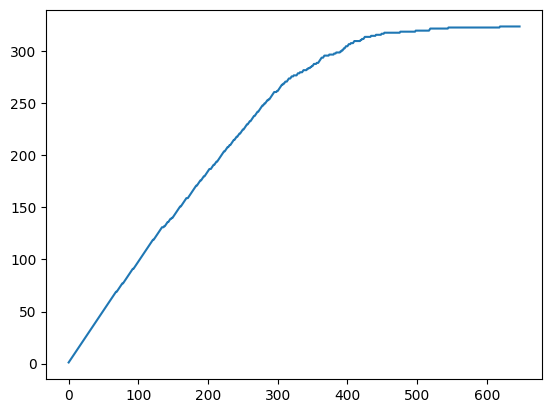

In [118]:
# cum sum over sorted targets
cumsum = np.cumsum(sorted_targets)

# plot
plt.plot(cumsum)

In [119]:
for i in range(10):
    get_song_by_id(sorted_ids[::-1][i])

### Use Case 2: Measuring Model Bias Using TCAV


In [128]:
from collections import defaultdict
from matplotlib.patches import Patch
from scipy.stats import ttest_1samp


def calculate_tcav_scores(
    cav_vectors: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
    embedding_prefix: str,
    encoder_id: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = np.array([np.array(x) for x in df_subset.embedding.values])
        for cav_vector in cav_vectors:
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_vector, target_embeddings)
            )

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction: bool = True,
    verbose: bool = True,
) -> tuple[dict[str, float], float]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction:
        target_p_value_str = (
            f"({target_p_value} / {len(tcav_scores)}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / len(tcav_scores)
    else:
        target_p_value_str = f"{target_p_value}"

    p_values = {}
    for label, scores in tcav_scores.items():
        t_statistic, p_value = ttest_1samp(scores, 0.5)
        p_values[label] = p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {t_statistic}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return p_values, target_p_value


def plot_tcav_scores(
    tcav_scores: dict[str, list[float]],
    not_sigificant_labels: list[str],
    out_file_name: str | None = None,
    scatter: bool = False,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    colors = {
        "neutral": "#90A4AE",
        "positive": "#AED581",
        "negative": "#FF8A65",
    }

    tcav_scores = dict(
        sorted(tcav_scores.items(), key=lambda x: np.mean(x[1]), reverse=False)
    )

    plt.figure(figsize=(5, 4))
    labels = list(tcav_scores.keys())
    data = [scores for scores in tcav_scores.values()]

    if scatter:
        for i, (label, scores) in enumerate(tcav_scores.items()):
            plt.scatter(scores, [i + 1] * len(scores), alpha=0.6, edgecolors="w", s=20)
    else:
        box_colors = [
            colors["neutral"]
            if label in not_sigificant_labels
            else colors["positive"]
            if np.mean(scores) > 0.5
            else colors["negative"]
            for label, scores in zip(labels, data)
        ]

        bplot = plt.boxplot(
            data,
            vert=False,
            patch_artist=True,
            boxprops=dict(linewidth=0.5),
            flierprops=dict(marker="o", color="gray", alpha=0.5, markersize=3),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=1.5, color="firebrick"),
            meanprops=dict(
                marker="D",
                markeredgecolor="black",
                markerfacecolor="firebrick",
                markersize=3,
            ),
            showmeans=True,
        )

        for patch, color in zip(bplot["boxes"], box_colors):
            patch.set_facecolor(color)

    plt.axvline(0.5, color="black", linewidth=0.5)
    plt.yticks(range(1, len(labels) + 1), labels)

    plt.xticks(np.arange(0, 1.1, 0.25))
    plt.xlim(0, 1)

    plt.grid(axis="x", linestyle="--", linewidth=0.5)
    legend_elements = [
        Patch(facecolor=colors["positive"], label="Positive bias"),
        Patch(facecolor=colors["negative"], label="Negative bias"),
        Patch(facecolor=colors["neutral"], label="No significance"),
    ]
    plt.legend(handles=legend_elements, loc="lower right", fontsize="x-small")
    plt.tight_layout()

    if out_file_name:
        plt.savefig(out_file_name)
    plt.show()


def run_evaluations(evaluation_variations: list[tuple]):
    for project_name, encoder_id, target_column in evaluation_variations:
        print(f"Evaluating {project_name} with {encoder_id} on {target_column}")

        df_test = load_df_and_embeddings(
            project_name, "test", encoder_id, dataset_prefix, embedding_prefix, s3
        )

        cav_vector_dir = os.path.join(
            trainings_prefix,
            "trainings",
            encoder_id,
            project_name,
            f"cav_ttest_{project_name}.npy",
        )

        cav_vector = np.load(cav_vector_dir)

        tcav_scores = calculate_tcav_scores(
            cav_vector, df_test, target_column, embedding_prefix, encoder_id
        )
        p_values, target_p_value = t_test_on_tcav_scores(tcav_scores, verbose=False)

        genres_to_accept_h0 = [
            genre for genre, p in p_values.items() if p >= target_p_value
        ]

        file_name = os.path.join(
            "plots",
            f"tcav_ttest_{encoder_id}_{project_name}_{target_column}.png",
        )

        plot_tcav_scores(tcav_scores, genres_to_accept_h0, file_name)


Evaluating language_fr with mert_v1_95m on genre


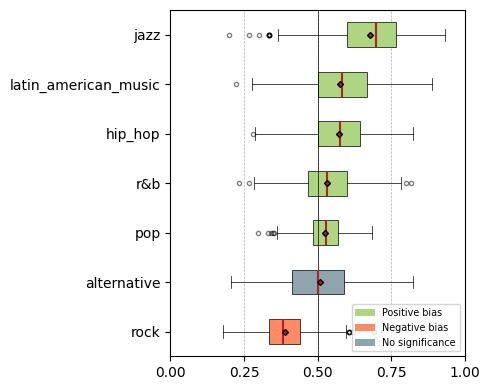

Evaluating language_fr with whisper_large_v2 on genre


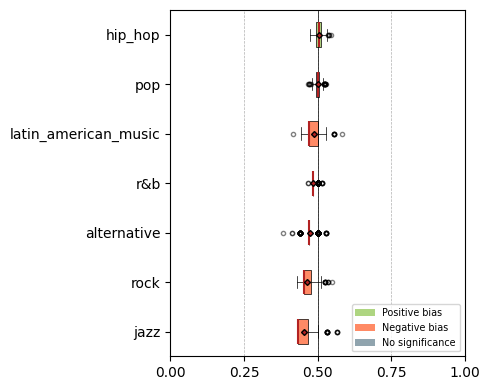

Evaluating language_fr with muq_large_msd on genre


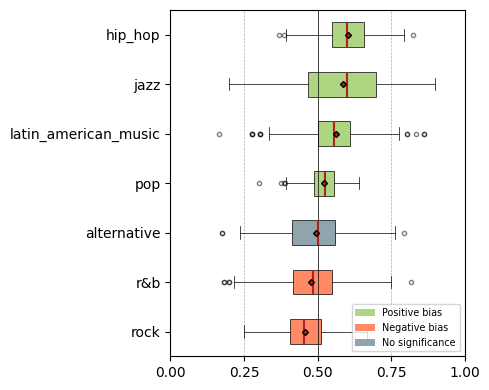

Evaluating language_fr with muq_mulan_large on genre


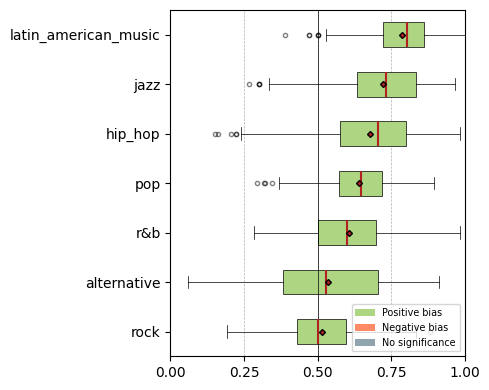

In [131]:
evaluation_variations = [*itertools.product(project_names, encoder_ids, target_columns)]

results = run_evaluations(evaluation_variations)